In [69]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import shap

In [2]:
def model_evaluation(X_train, y_train, X_test, y_test, model):
    print(f" Test MAE: {mean_absolute_error(y_test, model.predict(X_test))}")
    print(f" Train MAE: {mean_absolute_error(y_train, model.predict(X_train))}")
    print(f" Train Accuracy: {model.score(X_train, y_train)}")
    print(f" Test Accuracy: {model.score(X_test, y_test)}")

In [3]:
df = pd.read_csv('seasonal_phen_dataset.csv')

In [4]:
df.shape

(3224, 340)

# Feature cleaning

### drop all one value feature 

In [5]:
for col in df.columns:
    if df[col].value_counts().count() == 1:
        df.drop([col], axis=1, inplace=True)

### drop anomalies in "Sitlav - Soybeans - Yield - KG/Ha"

In [6]:
drop_anomalies_list = df[df['Sitlav - Soybeans - Yield - KG/Ha'] >= 10000]
df = df.drop([987, 1451], axis=0)

### Drop row if "plot code" is null

In [7]:
df['plot code'].isnull().value_counts()

False    3218
True        4
Name: plot code, dtype: int64

In [8]:
df = df[df['plot code'].notna()]

In [9]:
df['plot code'].isnull().value_counts()

False    3218
Name: plot code, dtype: int64

In [10]:
df['Season code'].isnull().value_counts()

False    3218
Name: Season code, dtype: int64

## Feature Engineering

### The categorical variables prep

In [14]:
categorical = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))
print('The categorical variables are :', categorical)

There are 3 categorical variables
The categorical variables are : ['plot code', 'Season code', 'CLASSE_DOM']


In [15]:
def one_hot_encoding(pandas_series):    
    # Apply one-hot encoding
    one_hot = pd.get_dummies(pandas_series)
    return(one_hot)

#### CLASSE_DOM

In [16]:
df['CLASSE_DOM'].value_counts()

LVAd    1323
LVd      749
RQo      675
FFc      183
PVAd     152
RLd      107
LAd       23
PVe        6
Name: CLASSE_DOM, dtype: int64

In [17]:
df.shape

(3218, 327)

In [18]:
df = pd.concat([df, one_hot_encoding(df['CLASSE_DOM'])], axis=1)
df = df.drop(['CLASSE_DOM'], axis=1)

In [19]:
df.shape

(3218, 334)

#### plot code

In [20]:
from sklearn.preprocessing import LabelEncoder
# Label encoding: In this method, each category is assigned a unique numerical value. 
def Label_Encoder(pandas_series):
    le = LabelEncoder()
    label_encoded = le.fit_transform(pandas_series)
    return(label_encoded)

In [21]:
df['plot code'].value_counts()

AL549648Z    3
AL549267Z    3
AL549294Z    3
AL549290Z    3
AL549284Z    3
            ..
AL549751Z    1
AL549752Z    1
AL551731Z    1
AL549753Z    1
AL551419Z    1
Name: plot code, Length: 1379, dtype: int64

In [22]:
df['plot code'] = Label_Encoder(df['plot code'])

In [23]:
df['plot code'].value_counts()

919     3
693     3
719     3
715     3
709     3
       ..
929     1
930     1
1264    1
931     1
1146    1
Name: plot code, Length: 1379, dtype: int64

In [24]:
df['Sitlav - Soybeans - Yield - KG/Ha'].isnull().sum()

0

#### Fill missing values

In [25]:
for col in df.columns:
    s = df[col].value_counts(normalize=True)
    missing = df[col].isnull()
    df.loc[missing,col] = np.random.choice(s.index, size=len(df[missing]),p=s.values)

In [26]:
df.isnull().sum()

plot code                            0
Season code                          0
Sitlav - Soybeans - Yield - KG/Ha    0
mean_phen_savi2_1                    0
max_phen_savi2_1                     0
                                    ..
LVd                                  0
PVAd                                 0
PVe                                  0
RLd                                  0
RQo                                  0
Length: 334, dtype: int64

In [27]:
df.groupby(['plot code', 'Season code', 'Sitlav - Soybeans - Yield - KG/Ha']).count().reset_index()

,plot code,Season code,Sitlav - Soybeans - Yield - KG/Ha,mean_phen_savi2_1,max_phen_savi2_1,std_phen_savi2_1,skew_phen_savi2_1,kurt_phen_savi2_1,mean_phen_savi2_2,max_phen_savi2_2,...,mean_soc_30_60,mean_soc_5_15,FFc,LAd,LVAd,LVd,PVAd,PVe,RLd,RQo
0,0,CR196IKKIJ5Z,3789.8,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,CR196LWQ0DXZ,4666.8,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,0,CR196PUJKZ,2451.5,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,CR196J6Q05CZ,4090.0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,CR196P7HHZ,3930.6,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3213,1374,CR196NRQ0NHZ,3386.2,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3214,1375,CR196ILEIG8Z,4283.5,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3215,1376,CR196PGQ046Z,4705.7,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3216,1377,CR196LHPSZ,3365.0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


# Data prep

### Feature selection

In [28]:
y = df['Sitlav - Soybeans - Yield - KG/Ha'].copy()
X = df.drop(['Sitlav - Soybeans - Yield - KG/Ha', 'Season code'], axis=1)

In [29]:
X.shape, y.shape

((3218, 332), (3218,))

In [30]:
def feature_selection(estimator, X, y):
    selector = SelectFromModel(estimator=estimator).fit(X, y)
    filter_list = selector.get_support()
    filtered_list = [x for x, condition in zip(X.columns, filter_list) if condition]
    return (filtered_list)

In [31]:
filtered_list = feature_selection(LinearRegression(), X, y)
# filtered_list = feature_selection(RidgeCV(), X, y)
# filtered_list = feature_selection(LassoCV(), X, y)

In [32]:
X = X[filtered_list]

### Train test split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Scaling features to a range

In [34]:
min_max_scaler = MinMaxScaler()
max_abs_scaler = MaxAbsScaler()

In [35]:
def Normalization(scaler, X_train, X_test):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    return (X_train, X_test)

In [36]:
X_train, X_test = Normalization(min_max_scaler, X_train, X_test)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2574, 40), (644, 40), (2574,), (644,))

### Building the model

# Linear Regression model

In [38]:
# Linear Regression model
# Assigning the algorithm to the variable
lr = LinearRegression()

# Fitting of the model
lr.fit(X_train, y_train)

LinearRegression()

In [39]:
lr_y_train_pred = lr.predict(X_train)
lr_y_test_pred = lr.predict(X_test)

In [67]:
def model_evaluation(X_train, y_train, X_test, y_test):
    # Evaluate model performance
    mse = mean_squared_error(y_test, lr_y_test_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test - lr_y_test_pred))
    r2 = r2_score(y_test, lr_y_test_pred)

    # the average squared difference between the predicted and actual values. A lower MSE indicates better performance.
    print('MSE:', mse)
    # square root of the MSE. A lower RMSE indicates better performance.
    print('RMSE:', rmse)
    # The average absolute difference between the predicted and actual values. 
    # It is less sensitive to outliers compared to the MSE and RMSE.
    print('MAE:', mae)
    # the dependent variable that is explained by the independent variables in the model. 
    # An R^2 value closer to 1 indicates better performance.
    print('R^2:', r2)

In [68]:
model_evaluation(X_train, y_train, X_test, y_test)

MSE: 408634.1503125484
RMSE: 639.244984581458
MAE: 473.93919508262974
R^2: 0.04685735381621514


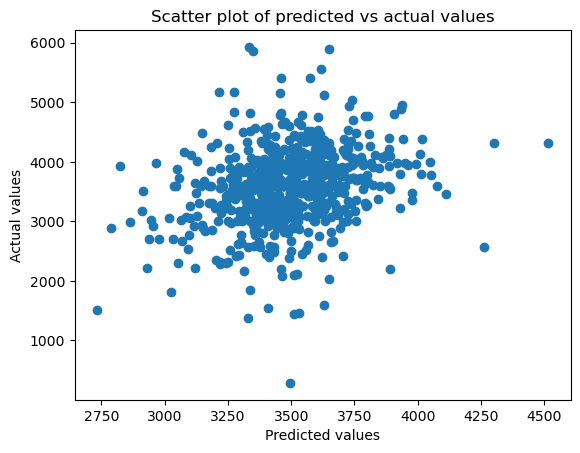

In [58]:
# Create scatter plot
plt.scatter(lr_y_test_pred, y_test)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Scatter plot of predicted vs actual values')
plt.show()

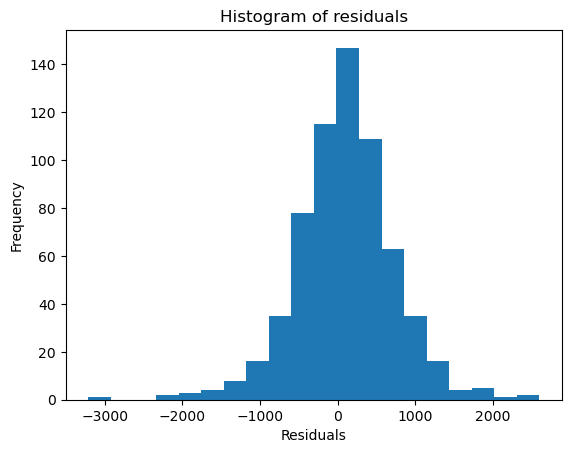

In [60]:
# Create residual plot lc_y_train_pred, 
residuals = y_test - lr_y_test_pred
# Create histogram of residuals
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of residuals')
plt.show()

### The residuals are normally distributed

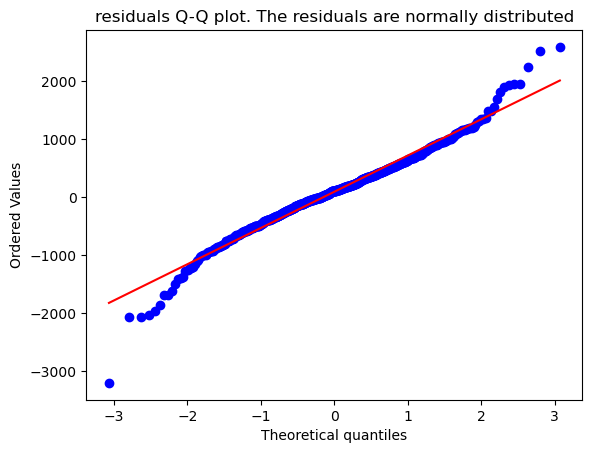

In [65]:
# Create Q-Q plot of residuals
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('residuals Q-Q plot')
plt.show()

# RidgeCV model

In [41]:
# RidgeCV model
# Assigning the algorithm to the variable
rc = RidgeCV()

# Fitting of the model
rc.fit(X_train,y_train)

RidgeCV()

In [42]:
rc_y_train_pred = rc.predict(X_train)
rc_y_test_pred = rc.predict(X_test)

In [43]:
model_evaluation(X_train, y_train, X_test, y_test, rc)

 Test MAE: 472.89139760014996
 Train MAE: 455.6218767092939
 Train Accuracy: 0.08707953617773134
 Test Accuracy: 0.05284937674594803


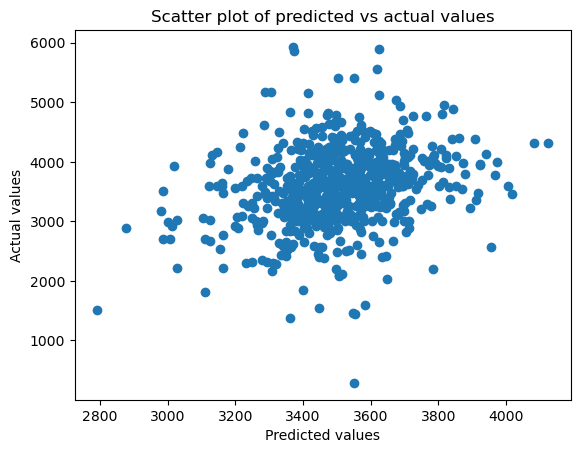

In [55]:
# Create scatter plot
plt.scatter(rc_y_test_pred, y_test)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Scatter plot of predicted vs actual values')
plt.show()

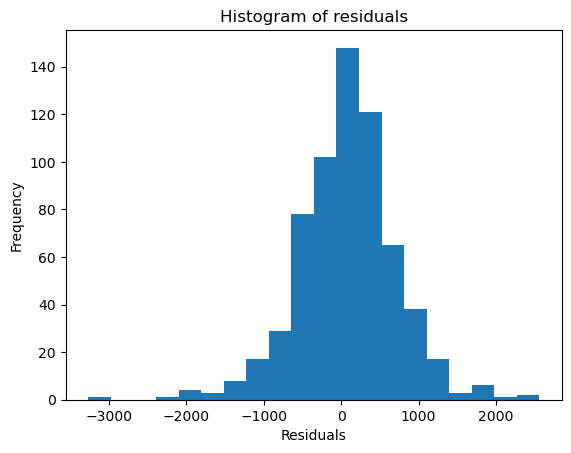

In [56]:
# Create residual plot lc_y_train_pred, 
residuals = y_test - rc_y_test_pred
# Create histogram of residuals
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of residuals')
plt.show()

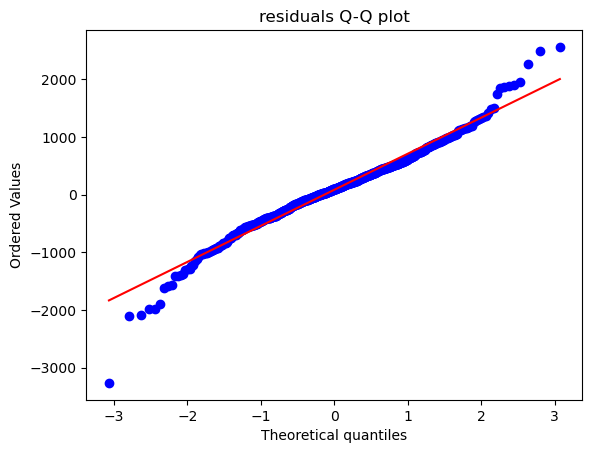

In [57]:
# Create Q-Q plot of residuals
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('residuals Q-Q plot')
plt.show()

# LassoCV model

In [45]:
# LassoCV model
# Assigning the algorithm to the variable
lc = LassoCV()

# Fitting of the model
lc.fit(X_train,y_train)

LassoCV()

In [46]:
lc_y_train_pred = lc.predict(X_train)
lc_y_test_pred = lc.predict(X_test)

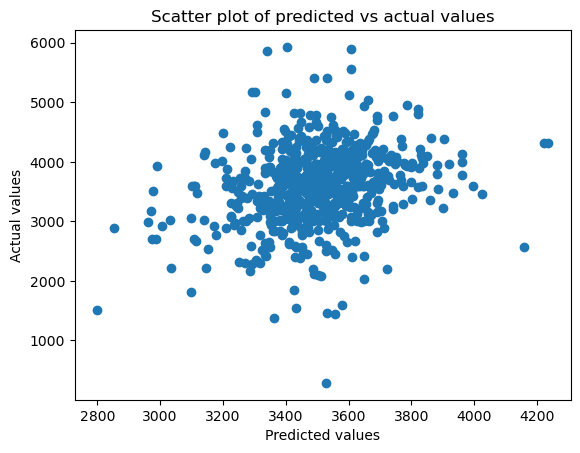

In [53]:
# Create scatter plot
plt.scatter(lc_y_test_pred, y_test)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Scatter plot of predicted vs actual values')
plt.show()

In [48]:
model_evaluation(X_train, y_train, X_test, y_test, lc)

 Test MAE: 474.72383712452324
 Train MAE: 455.2787521804178
 Train Accuracy: 0.08669612816271721
 Test Accuracy: 0.0454988327213427


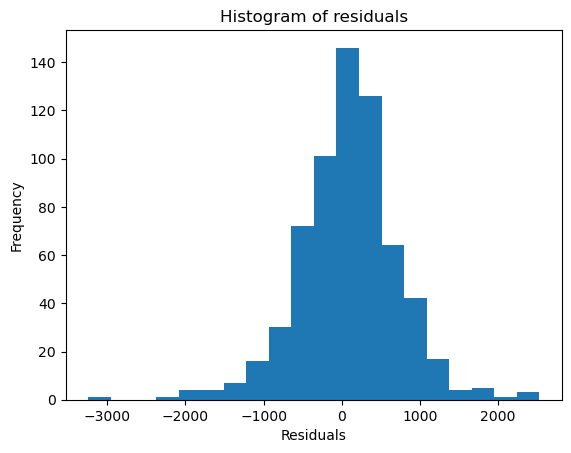

In [49]:
# Create residual plot lc_y_train_pred, 
residuals = y_test - lc_y_test_pred
# Create histogram of residuals
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of residuals')
plt.show()

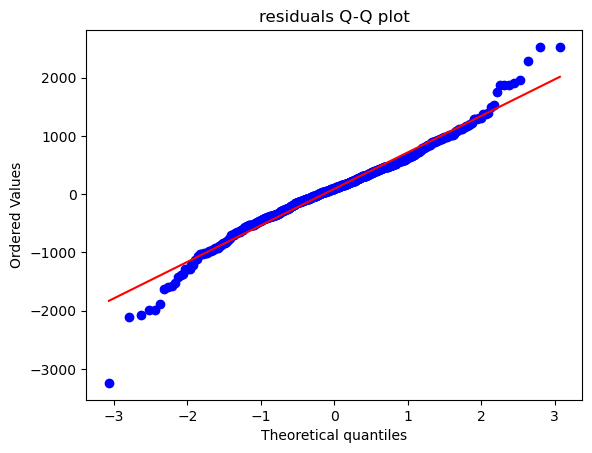

In [52]:
# Create Q-Q plot of residuals
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('residuals Q-Q plot')
plt.show()

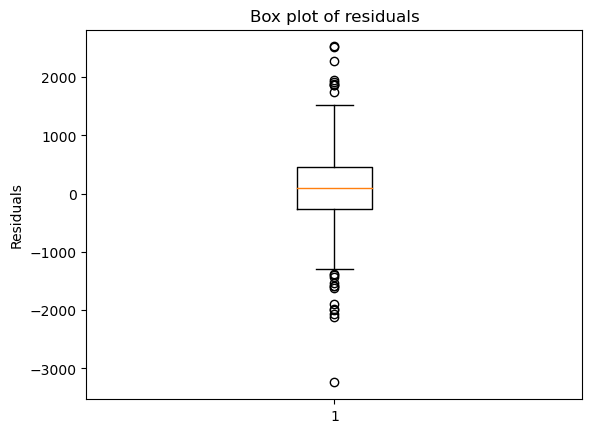

In [51]:
# Create box plot of residuals
plt.boxplot(residuals)
plt.ylabel('Residuals')
plt.title('Box plot of residuals')
plt.show()

In [122]:
from sklearn.ensemble import RandomForestRegressor

In [124]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [125]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(regressor)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train, feature_names=features, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train, feature_names=features)

In [ ]:
print(f"x_train shape {X.shape}")
print(f"y_train shape {y.shape}")
print(f"x_test shape {X.shape}")
print(f"y_test shape {y.shape}")

In [ ]:
plt.scatter(X_train['std_phen_savi2_2'], y_train, color = 'red')
plt.xlabel('std_phen_savi2_2')
plt.ylabel('Sitlav - Soybeans - Yield - KG/Ha')
plt.show()

In [77]:
X.describe()

,mean_phen_savi2_1,max_phen_savi2_1,std_phen_savi2_1,mean_phen_savi2_2,max_phen_savi2_2,std_phen_savi2_2,mean_phen_savi2_3,max_phen_savi2_3,kurt_phen_savi2_3,mean_phen_savi2_4,...,max_phen_arvi_3,std_phen_msavi_1,std_phen_msavi_2,max_phen_cari_1,std_phen_cari_1,mean_phen_cari_2,max_phen_cari_2,std_phen_cari_2,mean_phen_cari_3,LAd
count,3218.000000,3218.000000,3.218000e+03,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3.218000e+03,3218.000000,3218.000000,3.218000e+03,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.017832,0.018224,3.923745e-04,0.029539,0.032345,0.002716,0.035620,0.035553,4.994049,0.034010,...,0.786569,1.209042e-02,0.067033,0.416461,5.912556e-03,0.370479,0.395713,0.023129,0.312709,0.007147
std,0.002674,0.003014,9.890351e-04,0.007409,0.008205,0.003257,0.006042,0.006049,0.001825,0.006179,...,0.069858,3.129661e-02,0.079275,0.062649,1.596154e-02,0.056028,0.066363,0.031191,0.058705,0.084252
min,0.004527,0.004527,0.000000e+00,0.005163,0.005163,0.000000,0.008533,0.008533,4.988337,0.007627,...,0.335940,0.000000e+00,0.000000,0.109133,0.000000e+00,0.093497,0.093497,0.000000,0.075428,0.000000
25%,0.016352,0.016578,0.000000e+00,0.023802,0.025427,0.000000,0.032671,0.032651,4.992843,0.030840,...,0.758186,0.000000e+00,0.000000,0.377026,0.000000e+00,0.337527,0.356912,0.000000,0.277576,0.000000
50%,0.017900,0.018056,0.000000e+00,0.029138,0.032999,0.001257,0.036742,0.036731,4.993810,0.034841,...,0.802945,0.000000e+00,0.030944,0.418344,0.000000e+00,0.371436,0.393769,0.010808,0.309762,0.000000
75%,0.019253,0.019789,2.120000e-18,0.034745,0.038983,0.005209,0.039563,0.039559,4.995115,0.037789,...,0.832390,3.400000e-17,0.129736,0.456682,6.800000e-17,0.403748,0.432220,0.036496,0.343860,0.000000
max,0.039335,0.039335,7.786745e-03,0.052073,0.052073,0.017969,0.050541,0.050541,4.999660,0.053486,...,0.890429,2.343338e-01,0.332773,0.736230,1.720147e-01,0.658262,0.897707,0.271581,0.648547,1.000000


In [79]:
len(X_train[:][1]), len(y_train)

(40, 2574)

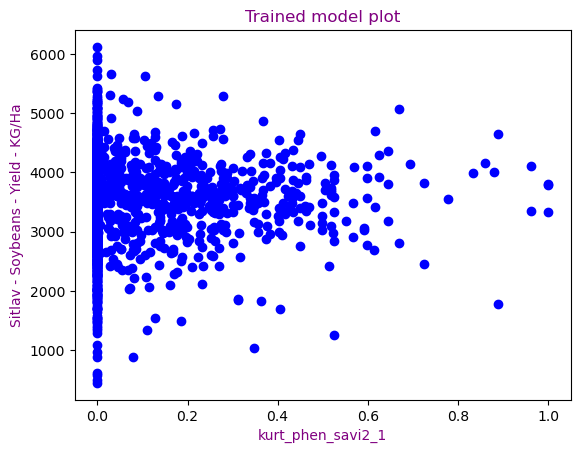

In [120]:
plt.scatter(X_train[:,2], y_train, color = "blue")
#plt.plot(X_test['kurt_phen_savi2_1'], lr_y_test_pred, color = "red")
plt.xlabel('kurt_phen_savi2_1', color = "purple")
plt.ylabel('Sitlav - Soybeans - Yield - KG/Ha', color = "purple")
plt.title('Trained model plot', color = "purple")
plt.plot;